# Stack Overflow Data Federated Text Generation with LSTM
- Joel Stremmel
- 01-17-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation example notebook listed in the references section.

**Notes:**

There are two modeling options within this notebook based on the tutorials listed under references:
1. To load a pretrained RNN as in the FL example using the Shakespeare dataset.
2. To build and train a basic LSTM model from scratch with the architecure in the TF text generation tutorial.


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Setup

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow -y
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections
import functools
import os
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
tf.compat.v1.enable_v2_behavior()

In [5]:
np.random.seed(0)

### Check Tensorflow Install

In [6]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Load Stack Overflow Data

In [10]:
train_data, val_data, test_data = tff.simulation.datasets.stackoverflow.load_data(cache_dir='~/data')

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### View Some Sample Client Records

In [11]:
raw_example_dataset = train_data.create_tf_dataset_for_client('00000001')
for record in raw_example_dataset.take(2):
    for key in record:
        print('\nKey: {}'.format(key))
        print(record[key])


Key: creation_date
tf.Tensor(b'2008-12-22 14:45:37.037 UTC', shape=(), dtype=string)

Key: score
tf.Tensor(11, shape=(), dtype=int64)

Key: tags
tf.Tensor(b'sql-server|indexing', shape=(), dtype=string)

Key: title
tf.Tensor(b'what fields should be indexed on a given table ?', shape=(), dtype=string)

Key: tokens
tf.Tensor(b'the sql server 2008 management studio query tool , if you turn on " include actual execution plan " , will tell you what indexes a given query needs to run fast .', shape=(), dtype=string)

Key: type
tf.Tensor(b'answer', shape=(), dtype=string)

Key: creation_date
tf.Tensor(b'2008-12-22 14:45:37.037 UTC', shape=(), dtype=string)

Key: score
tf.Tensor(11, shape=(), dtype=int64)

Key: tags
tf.Tensor(b'sql-server|indexing', shape=(), dtype=string)

Key: title
tf.Tensor(b'what fields should be indexed on a given table ?', shape=(), dtype=string)

Key: tokens
tf.Tensor(b"( assuming there's an obvious missing index that is making the query run unusually slow , that is .

### Count Number of Clients

In [12]:
print('{} train clients.'.format(len(train_data.client_ids)))
print('{} val clients.'.format(len(val_data.client_ids)))
print('{} test clients.'.format(len(test_data.client_ids)))

342477 train clients.
38758 val clients.
204088 test clients.


### Set Vocabulary
- Currently using the fixed vocabularly of ASCII chars that occur in the works of Shakespeare and Dickens
- **Is there a good way to get the distinct characters from a TF dataset?**

In [13]:
vocab = list('dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')
vocab_size = len(vocab)

### Creating a Mapping from Unique Characters to Indices

In [14]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

### Load a Pre-Trained Model
Text generation requires a batch_size=1 model.

In [15]:
def load_pretrained_model(batch_size):
    """
    Load a pretrained model from the Google RNNs trained on Dickens
    based on the desired batch size.
    """
    
    urls = {
        1: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch1.kerasmodel',
        8: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch8.kerasmodel'}
    
    assert batch_size in urls, 'batch_size must be in ' + str(urls.keys())
    
    url = urls[batch_size]
    local_file = tf.keras.utils.get_file(os.path.basename(url), origin=url)  
    
    return tf.keras.models.load_model(local_file, compile=False)

### Or Build and Train One from Random Initialization

In [16]:
def build_model(batch_size, vocab_size, embedding_dim=256, rnn_units=512):
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model = tf.keras.Sequential([
        
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim,
                                  batch_input_shape=[batch_size, None]),
                                 
        tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             recurrent_initializer='glorot_uniform'),
                                 
        tf.keras.layers.Dense(vocab_size)])
                 
    return model

### Define the Text Generation Strategy

In [17]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """

    num_generate = 200
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

### Load or Build the Model
Text generation requires a batch_size=1 model.

In [18]:
keras_model_batch1 = build_model(batch_size=1, vocab_size=vocab_size)
print(generate_text(keras_model_batch1, "How's the water today? "))

"Lacd
KdiOvs5zY#MHnI@!iV#


### Set Some Parameters for Preprocessing the Data and Training the Model

In [19]:
SEQ_LENGTH = 100
BATCH_SIZE = 16
BUFFER_SIZE = 5000

### Define Functions to Preprocess Federated Stack Overflow
- Using a namedtuple with keys x and y as the output type of the dataset keeps both TFF and Keras happy.
- Construct a lookup table to map string chars to indexes, using the vocab loaded above.
- Write functions for:
    - ID lookup
    - Splitting inputs and targets
    - Applying preprocessing steps to dataset
    - Taking clients and client records and applying preprocessing

In [20]:
BatchType = collections.namedtuple('BatchType', ['x', 'y'])

In [21]:
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=vocab,
        values=tf.constant(list(range(len(vocab))),
        dtype=tf.int64)),
    default_value=0)

In [22]:
def to_ids(x):
    
    s = tf.reshape(x['tokens'], shape=[1])
    chars = tf.strings.bytes_split(s).values
    ids = table.lookup(chars)
    
    return ids

In [23]:
def split_input_target(chunk):
    
    input_text = tf.map_fn(lambda x: x[:-1], chunk)
    target_text = tf.map_fn(lambda x: x[1:], chunk)
    
    return BatchType(input_text, target_text)

In [24]:
def preprocess(dataset):
    
    return (
        # Map ASCII chars to int64 indexes using the vocab
        dataset.map(to_ids)
        # Split into individual chars
        .unbatch()
        # Form example sequences of SEQ_LENGTH +1
        .batch(SEQ_LENGTH + 1, drop_remainder=True)
        # Shuffle and form minibatches
        .shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
        # And finally split into (input, target) tuples,
        # each of length SEQ_LENGTH.
        .map(split_input_target))

In [25]:
def preprocess_data_for_client(client, data_source):
    
    return preprocess(data_source.create_tf_dataset_for_client(client))

### Get Sample Clients for Validation and Testing
Note that the train clients will be sampled within the training loop, but we'll set the parameter for how many to sample here.

In [26]:
NUM_TRAIN_CLIENTS = 20
NUM_VAL_CLIENTS = 20
NUM_TEST_CLIENTS = 10

In [27]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

In [28]:
val_clients = get_sample_clients(val_data, num_clients=NUM_VAL_CLIENTS)
test_clients = get_sample_clients(test_data, num_clients=NUM_TEST_CLIENTS)

### Build and Preprocess the Validation and Test Datasets
Concatenate the validation and test datasets for evaluation with Keras.

In [29]:
val_dataset = functools.reduce(lambda d1, d2: d1.concatenate(d2), 
                               [preprocess_data_for_client(client, val_data) for client in val_clients])

test_dataset = functools.reduce(lambda d1, d2: d1.concatenate(d2), 
                                [preprocess_data_for_client(client, test_data) for client in test_clients])

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Define Lists to Track Loss and Accuracy at Each Training Round

In [30]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

### Define the Evaluation Function to Use During Training

In [31]:
def keras_evaluate(keras_model, state, val_dataset):
    
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    loss, accuracy = keras_model.evaluate(val_dataset, steps=2)
    
    val_loss.append(loss)
    val_accuracy.append(accuracy)

### Define Loss Function and Metrics

In [32]:
class FlattenedCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):

    def __init__(self, name='accuracy', dtype=None):
        super(FlattenedCategoricalAccuracy, self).__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(y_pred, [-1, len(vocab), 1])
        
        return super(FlattenedCategoricalAccuracy, self).update_state(y_true, y_pred, sample_weight)

In [33]:
def compile(keras_model):
    
    keras_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[FlattenedCategoricalAccuracy()]
    )
    
    return keras_model

### Load and Compile the Model
The keras model will be accessed as a global variable to create a copy to be called by TFF and will be updated within the training loop to follow.

In [34]:
keras_model = build_model(batch_size=BATCH_SIZE, vocab_size=vocab_size)
compile(keras_model)
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (16, None, 256)           22016     
_________________________________________________________________
lstm_1 (LSTM)                (16, None, 512)           1574912   
_________________________________________________________________
dense_1 (Dense)              (16, None, 86)            44118     
Total params: 1,641,046
Trainable params: 1,641,046
Non-trainable params: 0
_________________________________________________________________


### Create TFF Version of the Model to be Trained with Federated Averaging
- Clone the keras_model inside `create_tff_model()`, which TFF will call to produce a new copy of the model inside the graph that it will serialize.
- TFF uses a `dummy_batch` so it knows the types and shapes that your model expects.
- Build and serialize the Tensorflow graph with `build_federated_averaging_process`.

In [35]:
def create_tff_model():
    
    x = tf.constant(np.random.randint(1, len(vocab), size=[BATCH_SIZE, SEQ_LENGTH]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone = compile(tf.keras.models.clone_model(keras_model))
    
    return tff.learning.from_compiled_keras_model(keras_model_clone, dummy_batch=dummy_batch)

In [36]:
fed_avg = tff.learning.build_federated_averaging_process(model_fn=create_tff_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initialize the Federated Averaging Process and the Starting Model State

In [37]:
# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
# instead to use the default reference runtime.
if six.PY3:
    tff.framework.set_default_executor(tff.framework.create_local_executor())

In [38]:
# The state of the FL server, containing the model and optimization state.
state = fed_avg.initialize()

state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in keras_model.trainable_weights],
    non_trainable_weights=[v.numpy() for v in keras_model.non_trainable_weights]
)

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [39]:
NUM_ROUNDS = 100

for round_num in range(NUM_ROUNDS):
    
    # Examine validation metrics
    print(f'Evaluating before training round #{round_num} on {NUM_VAL_CLIENTS} clients.')
    keras_evaluate(keras_model, state, val_dataset)
    
    # Sample train clients to create a train dataset
    print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
    train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [preprocess_data_for_client(client, train_data) for client in train_clients]
    
    # Apply federated training round
    print('Applying federated training round.')
    state, metrics = fed_avg.next(state, train_datasets)
    
    # Examine training metrics
    print(f'Training metrics - loss: {metrics[1]:4.4f}; accuracy: {metrics[0]:4.4f}')
    train_loss.append(metrics[1])
    train_accuracy.append(metrics[0])

Evaluating before training round #0 on 20 clients.
2/2 [==============================] - 0s 192ms/step - loss: 4.4525 - accuracy: 0.0106
Sampling 20 new clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Applying federated training round.
Training metrics - loss: 2.6896; accuracy: 0.2945
Evaluating before training round #1 on 20 clients.
2/2 [==============================] - 0s 27ms/step - loss: 2.4982 - accuracy: 0.3313
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 2.3313; accuracy: 0.3427
Evaluating before training round #2 on 20 clients.
2/2 [==============================] - 0s 28ms/step - loss: 2.2387 - accuracy: 0.3797
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 2.1251; accuracy: 0.3957
Evaluating before training round #3 on 20 clients.
2/2 [==============================] - 0s 27ms/step - loss: 2.0728 - accuracy: 0.4303
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 2.0981; accuracy: 0.3977
Evaluating before training round #4 on 20 clients.
2/2 [==============================] - 0s 28ms/step - loss: 2.0841 - accuracy: 0.4334
Sampling 20 new clients.
Applying fed

Training metrics - loss: 1.3809; accuracy: 0.5997
Evaluating before training round #34 on 20 clients.
2/2 [==============================] - 0s 30ms/step - loss: 1.5403 - accuracy: 0.5759
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.3691; accuracy: 0.6015
Evaluating before training round #35 on 20 clients.
2/2 [==============================] - 0s 28ms/step - loss: 1.4767 - accuracy: 0.5934
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.3927; accuracy: 0.5963
Evaluating before training round #36 on 20 clients.
2/2 [==============================] - 0s 29ms/step - loss: 1.4097 - accuracy: 0.6150
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.3694; accuracy: 0.6021
Evaluating before training round #37 on 20 clients.
2/2 [==============================] - 0s 29ms/step - loss: 1.4772 - accuracy: 0.5881
Sampling 20 new clients.
Applying federated training round.
Training

2/2 [==============================] - 0s 30ms/step - loss: 1.3714 - accuracy: 0.6150
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.2791; accuracy: 0.6255
Evaluating before training round #68 on 20 clients.
2/2 [==============================] - 0s 29ms/step - loss: 1.2986 - accuracy: 0.6291
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.2927; accuracy: 0.6214
Evaluating before training round #69 on 20 clients.
2/2 [==============================] - 0s 28ms/step - loss: 1.4385 - accuracy: 0.5966
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.2581; accuracy: 0.6290
Evaluating before training round #70 on 20 clients.
2/2 [==============================] - 0s 28ms/step - loss: 1.4569 - accuracy: 0.6000
Sampling 20 new clients.
Applying federated training round.
Training metrics - loss: 1.2832; accuracy: 0.6245
Evaluating before training round #71 on 20 clients.
2/2 [===

### Plot Model Objective Function

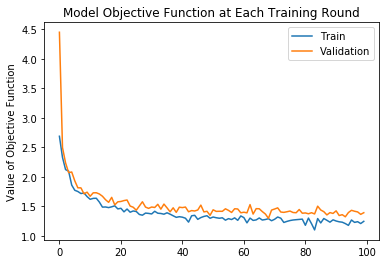

In [40]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss, label='Train')
ax.plot(x_axis, val_loss, label='Validation')
ax.legend(loc='best')
plt.ylabel('Value of Objective Function')
plt.title('Model Objective Function at Each Training Round')
plt.show()

### Plot Model Accuracy

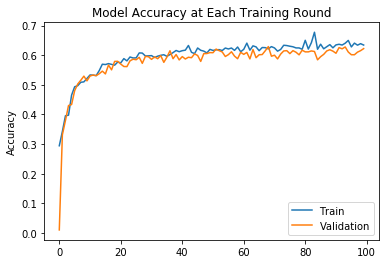

In [41]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy, label='Train')
ax.plot(x_axis, val_accuracy, label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()

### Get Final Evaluation

In [42]:
keras_evaluate(keras_model, state, val_dataset)

2/2 [==============================] - 0s 29ms/step - loss: 1.4139 - accuracy: 0.5969


### Generate Text
Text generation requires batch_size=1.

In [43]:
keras_model_batch1.set_weights([v.numpy() for v in keras_model.weights])
print(generate_text(keras_model_batch1, "How's the water today? "))

How's the water today? nges to porelllurarevad heradar p donpconture .ay ?enf ses de ple maw halep d anu harnghecomofax novoc foct ftimpprds yoevataprit , rorsecan antyngedioulll wifocon j t io esope t d luns wixte sinuthe 


**Suggested extensions:**

- Use ".repeat(NUM_EPOCHS)" on the client datasets to try multiple epochs of local training (e.g., as in McMahan et. al.). See also Federated Learning for Image Classification which does this.
- Change the compile() command to experiment with using different optimization algorithms on the client.
- Try the server_optimizer argument to build_federated_averaging_process to try different algorithms for applying the model updates on the server.
- Try the client_weight_fn argument to to build_federated_averaging_process to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. client_weight_fn=lambda _: tf.constant(1.0).